In [13]:
"""
In this file, we will first train an autoencoder with UA-detrac, cluster it and use the labels to train the DEC network
First we will have to do a manual examination of the result from autoencoder / cluster to see if it is appropriate to use it as a benchmark - No
If so, we will then compare the results with clustering using a distance approach with k-means and DEC algorithm
There is also a clustering method called hypergraph.. see if we have time for this
There are other clustering methods that don't require a predefined number of clusters...
However, for now, we will go about using k-means where the number of cluster is frame_num / 20
"""

%pylab inline
import os
import keras
import metrics
import cv2
import time
import numpy as np
import pandas as pd
import keras.backend as K
import tensorflow as tf

import sklearn.metrics as metrics

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

from sklearn.cluster import KMeans



Populating the interactive namespace from numpy and matplotlib


/nethome/jbang36/miniconda2/envs/pp36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
os.getcwd()
home_dir = os.path.abspath('../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac', 'small-data', 'MVI_20011')
data_dir

'/home/jbang36/eva/data/ua_detrac/small-data/MVI_20011'

In [3]:
def load_images_nn(image_dir, downsize_rate = 1):
    """
    Loading images in a non normalized form
    :param image_dir:
    :param downsize_rate:
    :param grayscale:
    :return:
    """
    image_height = 540
    image_width = 960
    file_names = []
    for root, subdirs, files in os.walk(image_dir):
        files.sort()
        for file in files:
            file_names.append(os.path.join(root, file))

    
    img_table = np.ndarray(shape=(len(file_names), int(image_height / downsize_rate), int(image_width / downsize_rate)))
    
    for i in range(len(file_names)):
        file_name = file_names[i]
        img = cv2.imread(file_name,0)
        img = cv2.resize(img, (image_width // downsize_rate, image_height // downsize_rate))
        img_table[i] = img

    return img_table

image_table = load_images_nn(data_dir, downsize_rate = 12)

In [4]:
# split the training and test data

n_samples = image_table.shape[0]
train_x = image_table[:int(n_samples * 0.8)]
test_x = image_table[int(n_samples * 0.8):]

(45, 80)


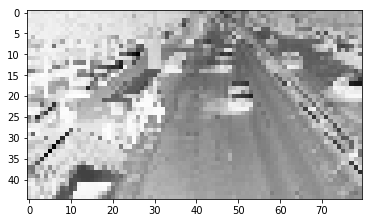

In [5]:
import matplotlib.pyplot as plt
import random
image_index = random.randint(0,100) # You may select anything up to 60,000
print(train_x[image_index].shape)

plt.imshow(train_x[image_index], cmap='Greys')

In [6]:
n_samples, width, height = image_table.shape
train_x = train_x.reshape(-1, width*height).astype('float32')
test_x = test_x.reshape(-1, width*height).astype('float32')

# Must perform normalization for the autoencoder to perform well
train_x /= 255.0
test_x /= 255.0 

In [10]:
"""
DEC Implementation


Keras implementation for Deep Embedded Clustering (DEC) algorithm:


Original Author:
    Xifeng Guo. 2017.1.30
"""


def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    x = Input(shape=(dims[0],), name='input')
    h = x

    # internal layers in encoder
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)

    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

    y = h
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

    # output
    y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

    return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DEC(object):
    def __init__(self,
                 dims,
                 n_clusters=10,
                 alpha=1.0,
                 init='glorot_uniform'):

        super(DEC, self).__init__()

        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.autoencoder, self.encoder = autoencoder(self.dims, init=init)

        # prepare DEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        self.model = Model(inputs=self.encoder.input, outputs=clustering_layer)

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='results/temp'):
        print('...Pretraining...')
        self.autoencoder.compile(optimizer=optimizer, loss='mse')

        csv_logger = callbacks.CSVLogger(save_dir + '/pretrain_log.csv')
        cb = [csv_logger]
        if y is not None:
            class PrintACC(callbacks.Callback):
                def __init__(self, x, y):
                    self.x = x
                    self.y = y
                    super(PrintACC, self).__init__()

                def on_epoch_end(self, epoch, logs=None):
                    if epoch % int(epochs/10) != 0:
                        return
                    feature_model = Model(self.model.input,
                                          self.model.get_layer(
                                              'encoder_%d' % (int(len(self.model.layers) / 2) - 1)).output)
                    features = feature_model.predict(self.x)
                    km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20, n_jobs=4)
                    y_pred = km.fit_predict(features)
                    # print()
                    print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|'
                          % (metrics.acc(self.y, y_pred), metrics.nmi(self.y, y_pred)))

            cb.append(PrintACC(x, y))

        # begin pretraining
        t0 = time.time()
        self.autoencoder.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=cb)
        print('Pretraining time: ', time.time() - t0)
        self.autoencoder.save_weights(save_dir + '/ae_weights.h5')
        print('Pretrained weights are saved to %s/ae_weights.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights):  # load weights of DEC model
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.encoder.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./results/temp'):

        print('Update interval', update_interval)
        save_interval = x.shape[0] / batch_size * 5  # 5 epochs
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time.time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/dec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(metrics.acc(y, y_pred), 5)
                    nmi = np.round(metrics.nmi(y, y_pred), 5)
                    ari = np.round(metrics.ari(y, y_pred), 5)
                    loss = np.round(loss, 5)
                    logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, loss=loss)
                    logwriter.writerow(logdict)
                    print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            # if index == 0:
            #     np.random.shuffle(index_array)
            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            self.model.train_on_batch(x=x[idx], y=p[idx])
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # save intermediate model
            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/DEC_model_final.h5')
        self.model.save_weights(save_dir + '/DEC_model_final.h5')

        return y_pred




In [15]:
# setting the hyper parameters
init = 'glorot_uniform'
pretrain_optimizer = 'adam'
dataset = 'mnist'
batch_size = 2048
maxiter = 2e4
tol = 0.001
save_dir = 'detrac_results'

import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

update_interval = 200
pretrain_epochs = 500
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                       distribution='uniform')  # [-limit, limit], limit=sqrt(1./fan_in)
#pretrain_optimizer = SGD(lr=1, momentum=0.9)


# prepare the DEC model
fps = 20
n_clusters = train_x.shape[0] // fps
print("number of clusters is: " , n_clusters)
dec = DEC(dims=[train_x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, init=init)


dec.pretrain(x=train_x, y=None, optimizer=pretrain_optimizer,
             epochs=pretrain_epochs, batch_size=batch_size,
             save_dir=save_dir)

...Pretraining...
Epoch 1/500
531/531 [==============================] - 2s 4ms/step - loss: 0.2446
Epoch 2/500
531/531 [==============================] - 0s 164us/step - loss: 0.2436
Epoch 3/500
531/531 [==============================] - 0s 150us/step - loss: 0.2363
Epoch 4/500
531/531 [==============================] - 0s 154us/step - loss: 0.1882
Epoch 5/500
531/531 [==============================] - 0s 72us/step - loss: 0.6389
Epoch 6/500
531/531 [==============================] - 0s 128us/step - loss: 0.1202
Epoch 7/500
531/531 [==============================] - 0s 138us/step - loss: 0.1816
Epoch 8/500
531/531 [==============================] - 0s 140us/step - loss: 0.2154
Epoch 9/500
531/531 [==============================] - 0s 146us/step - loss: 0.2263
Epoch 10/500
531/531 [==============================] - 0s 143us/step - loss: 0.2268
Epoch 11/500
531/531 [==============================] - 0s 75us/step - loss: 0.2189
Epoch 12/500
531/531 [==============================] - 0s 1

Epoch 98/500
531/531 [==============================] - 0s 143us/step - loss: 0.0140
Epoch 99/500
531/531 [==============================] - 0s 136us/step - loss: 0.0140
Epoch 100/500
531/531 [==============================] - 0s 136us/step - loss: 0.0140
Epoch 101/500
531/531 [==============================] - 0s 142us/step - loss: 0.0140
Epoch 102/500
531/531 [==============================] - 0s 175us/step - loss: 0.0140
Epoch 103/500
531/531 [==============================] - 0s 180us/step - loss: 0.0140
Epoch 104/500
531/531 [==============================] - 0s 145us/step - loss: 0.0140
Epoch 105/500
531/531 [==============================] - 0s 145us/step - loss: 0.0140
Epoch 106/500
531/531 [==============================] - 0s 142us/step - loss: 0.0140
Epoch 107/500
531/531 [==============================] - 0s 137us/step - loss: 0.0140
Epoch 108/500
531/531 [==============================] - 0s 141us/step - loss: 0.0140
Epoch 109/500
531/531 [==============================] -

Epoch 194/500
531/531 [==============================] - 0s 85us/step - loss: 0.0140
Epoch 195/500
531/531 [==============================] - 0s 90us/step - loss: 0.0140
Epoch 196/500
531/531 [==============================] - 0s 87us/step - loss: 0.0140
Epoch 197/500
531/531 [==============================] - 0s 88us/step - loss: 0.0140
Epoch 198/500
531/531 [==============================] - 0s 89us/step - loss: 0.0140
Epoch 199/500
531/531 [==============================] - 0s 105us/step - loss: 0.0140
Epoch 200/500
531/531 [==============================] - 0s 86us/step - loss: 0.0140
Epoch 201/500
531/531 [==============================] - 0s 139us/step - loss: 0.0140
Epoch 202/500
531/531 [==============================] - 0s 156us/step - loss: 0.0140
Epoch 203/500
531/531 [==============================] - 0s 114us/step - loss: 0.0140
Epoch 204/500
531/531 [==============================] - 0s 126us/step - loss: 0.0140
Epoch 205/500
531/531 [==============================] - 0s 

Epoch 290/500
531/531 [==============================] - 0s 90us/step - loss: 0.0140
Epoch 291/500
531/531 [==============================] - 0s 87us/step - loss: 0.0140
Epoch 292/500
531/531 [==============================] - 0s 87us/step - loss: 0.0140
Epoch 293/500
531/531 [==============================] - 0s 89us/step - loss: 0.0140
Epoch 294/500
531/531 [==============================] - 0s 85us/step - loss: 0.0140
Epoch 295/500
531/531 [==============================] - 0s 90us/step - loss: 0.0140
Epoch 296/500
531/531 [==============================] - 0s 86us/step - loss: 0.0140
Epoch 297/500
531/531 [==============================] - 0s 92us/step - loss: 0.0140
Epoch 298/500
531/531 [==============================] - 0s 94us/step - loss: 0.0140
Epoch 299/500
531/531 [==============================] - 0s 89us/step - loss: 0.0140
Epoch 300/500
531/531 [==============================] - 0s 92us/step - loss: 0.0140
Epoch 301/500
531/531 [==============================] - 0s 87us/

Epoch 386/500
531/531 [==============================] - 0s 137us/step - loss: 0.0140
Epoch 387/500
531/531 [==============================] - 0s 138us/step - loss: 0.0140
Epoch 388/500
531/531 [==============================] - 0s 157us/step - loss: 0.0140
Epoch 389/500
531/531 [==============================] - 0s 127us/step - loss: 0.0140
Epoch 390/500
531/531 [==============================] - 0s 147us/step - loss: 0.0140
Epoch 391/500
531/531 [==============================] - 0s 145us/step - loss: 0.0140
Epoch 392/500
531/531 [==============================] - 0s 158us/step - loss: 0.0140
Epoch 393/500
531/531 [==============================] - 0s 144us/step - loss: 0.0140
Epoch 394/500
531/531 [==============================] - 0s 160us/step - loss: 0.0140
Epoch 395/500
531/531 [==============================] - 0s 139us/step - loss: 0.0140
Epoch 396/500
531/531 [==============================] - 0s 139us/step - loss: 0.0140
Epoch 397/500
531/531 [==============================]

Epoch 482/500
531/531 [==============================] - 0s 136us/step - loss: 0.0140
Epoch 483/500
531/531 [==============================] - 0s 107us/step - loss: 0.0140
Epoch 484/500
531/531 [==============================] - 0s 155us/step - loss: 0.0140
Epoch 485/500
531/531 [==============================] - 0s 168us/step - loss: 0.0140
Epoch 486/500
531/531 [==============================] - 0s 90us/step - loss: 0.0140
Epoch 487/500
531/531 [==============================] - 0s 142us/step - loss: 0.0140
Epoch 488/500
531/531 [==============================] - 0s 72us/step - loss: 0.0140
Epoch 489/500
531/531 [==============================] - 0s 90us/step - loss: 0.0140
Epoch 490/500
531/531 [==============================] - 0s 101us/step - loss: 0.0140
Epoch 491/500
531/531 [==============================] - 0s 86us/step - loss: 0.0140
Epoch 492/500
531/531 [==============================] - 0s 90us/step - loss: 0.0140
Epoch 493/500
531/531 [==============================] - 0s

In [16]:
dec.model.summary()
dec.compile(optimizer=SGD(0.01, 0.9), loss='kld')





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 3600)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               1800500   
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 26)                260       
Total params: 3,073,270
Trainable params: 3,073,270
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Fit the training data
y_pred = dec.fit(train_x, y=None, tol=tol, maxiter=maxiter, batch_size=batch_size,
                 update_interval=update_interval, save_dir=save_dir)

Update interval 200
Save interval 1.29638671875
Initializing cluster centers with k-means.
saving model to: detrac_results/DEC_model_0.h5
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.
saving model to: detrac_results/DEC_model_final.h5


In [18]:
# give predictions
pred_val = dec.predict(test_x)

In [20]:
print(pred_val)

[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10]


In [ ]:
# AUTOENCODER + KMEANS
# We will first train the autoencoder network + k means to train the DEC network
# We will see if the DEC network can improve upon the predictions made / compare and contrast by
# Selecting 3 frames from each group

# this is our input placeholder
input_img = Input(shape=(width*height,))

# "encoded" is the encoded representation of the input
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(width*height)(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

autoencoder.summary()

# Use of autoencoder + kmeans

import time

encoder = Model(input_img, encoded)
autoencoder.compile(optimizer='adam', loss='mse')
start_time = time.time()
train_history = autoencoder.fit(train_x, train_x, epochs=500, batch_size=2048, validation_data=(test_x, test_x))
print("Total time it took to train autoencoder is ", time.time() - start_time, " seconds")

#from scipy.misc import imread
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

pred_auto_train = encoder.predict(train_x)
pred_auto = encoder.predict(test_x)

print(pred_auto_train.shape)
print(pred_auto.shape)

km_auto = KMeans(n_jobs=-1, n_clusters=, n_init=20)


start_time = time.time()
km_auto.fit(pred_auto_train)
print("Total time it took to train k_means is ", time.time() - start_time, " seconds")

pred = km_auto.predict(pred_auto)